## Метрические методы классификации и регрессии

**Библиотеки**

In [5]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist  # расстояние между массивами данных
import numpy as np
import torch

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification  # генерирование датасетов
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

**1. Метрические классификаторы**

Основное свойство метрического классификатора в том, что в данном случае не нужны признаки, а важна только функция расстояния.

Почему мы можем отказаться от признакового описания объектов? При изучении SVM будет получено следующее выражение для линейного классификатора:
<center>$
\begin{equation*}
    \hat{\mathbf{w}}=
    \sum_{i=1}^{l}{
        \lambda_i\mathbf{x}_i
    }
\end{equation*}
$,</center>

где $\mathbf{x}_i$ - признаковое описание $i$-го объекта. Теперь, чтобы получить предсказания модели получаем:

<center>$
\begin{equation*}
    y=
    sign\left(
        \hat{\mathbf{w}}^T\mathbf{x}
    \right)=
    sign\left(
        \sum_{i=1}^{l}{
            \lambda_i\mathbf{x}_i^T\mathbf{x}
        }
    \right)
\end{equation*}
$</center>

Заметим, что скалярное произведение $\mathbf{x}_i^T\mathbf{x}$ не является метрикой, но оно представляет идею того, что предсказания не зависят от признаков объектов, а только от некоторой числовой характеристики.

**Датасет**

In [6]:
X, Y = make_classification(n_samples=150, n_features=2,
                           n_informative=2, n_classes=3,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=50,
                                                    random_state=0)

Выборка:
* `n_samples=150` - $150$ объектов;
* `n_features=2` - $2$ признака;
* `n_classes=3` - $3$ класса.

**1.1. Метод ближайшего соседа**

In [7]:
model = KNeighborsClassifier(n_neighbors=1)
_ = model.fit(X_train, Y_train)

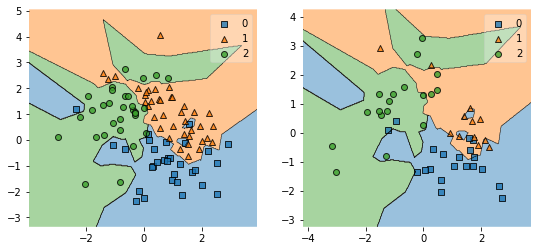

In [8]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    
plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

На рисунке. Слева - все объекты обучающей выборки. Справа - все объекты отложенной выборки.

Минус данного построения заключается в том, что мы рассматриваем одного соседа каждого объекта, и каждый объект принимается за своего единственного соседа.

Также ввиду малого числа соседей, области на графике представлены в виде кусочно-линейных функций, разделяющих пары обектов из различных классов.

**1.2. Метод $k$-ближайших соседей**

In [9]:
models = []
for n_neighbors in range(1, 50):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, Y_train)
    models.append(model)

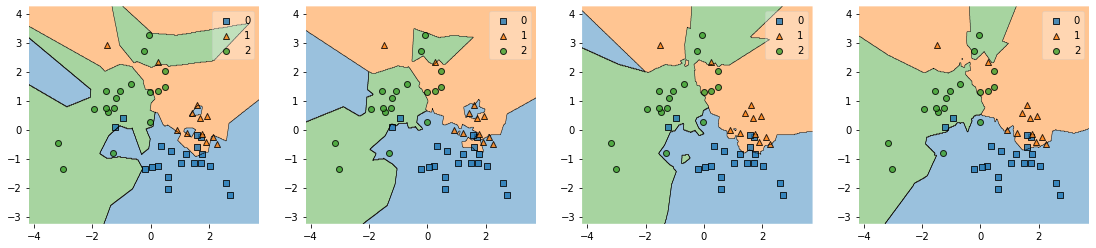

In [10]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, Y_test, models[i], ax=ax[i])
    
plt.show()

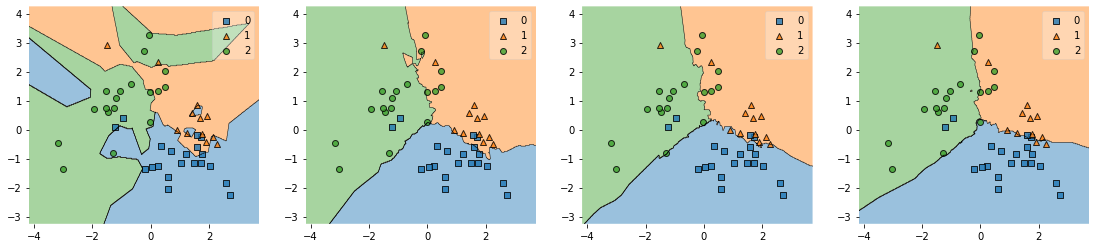

In [11]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, Y_test, models[12*i], ax=ax[i])
    
plt.show()

**1.3. Метод $k$-ближайших соседей с линейно убывающими весами**

Веса будут зависеть от порядкового номера соседа.

In [12]:
def func(distance):
    # distance - упорядоченная матрица расстояний
    # кол-во объектов для классификации - кол-во строк матрицы distance
    # кол-во столбцов - кол-во ближайших соседей ~ k
    ret = np.ones_like(distance)
    k = ret.shape[1]
    for i in range(k):
        ret[:, i] *= (k-i)/k
    return ret

In [14]:
models = []
for n_neighbors in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=n_neighbors,
                                 weights=func)
    # weights=func - функция взвешивания объектов
    model.fit(X_train, Y_train)
    models.append(model)

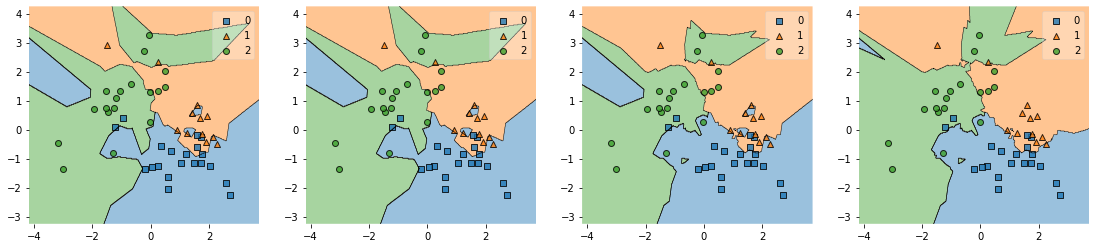

In [15]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, Y_test, models[i], ax=ax[i])
    
plt.show()

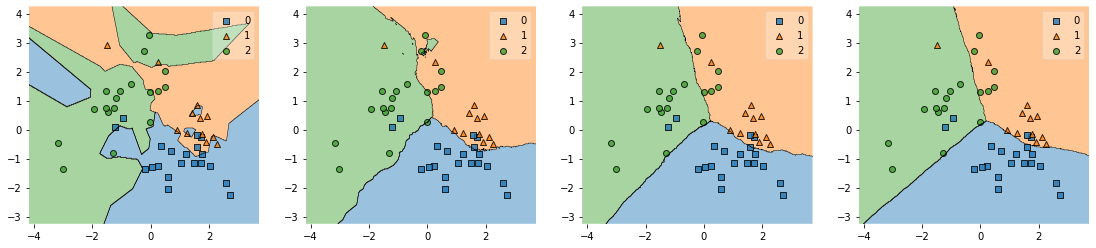

In [16]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, Y_test, models[12*i], ax=ax[i])
    
plt.show()

**1.4. Метод окна Парзена**

In [18]:
# Квадратичное ядро
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

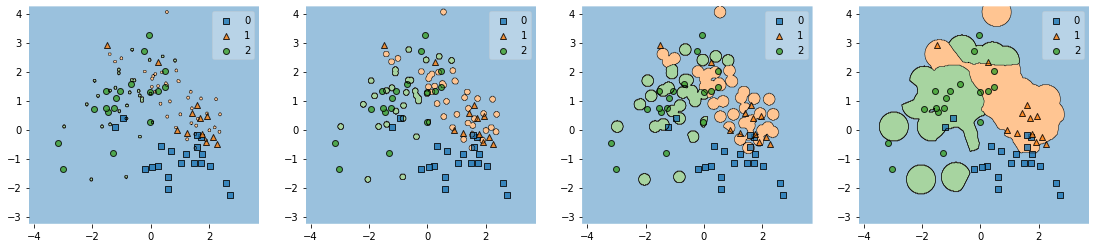

In [22]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i,h in enumerate([0.05, 0.1, 0.2, 0.5]):
    model = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

Маленькие области на первых двух картинках - окрестности вокруг точек обучающей выборки. Область представляет собой окружность так как а данном случае метрика является евклидовой.

Функция KNeighborsClassifier утроена так, что если она не может распознать никакой класс, то она возвращает $0$. Но на самом деле синие области (класс $0$) можно обозначить как области, на которых классификатор отказывается работать, потому что в данной области все классы равновероятны.

Рассмотрим более крупные окна.

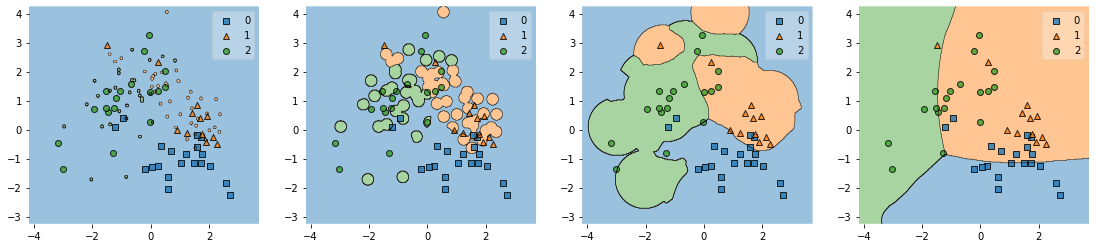

In [23]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i,h in enumerate([0.05, 0.2, 1.0, 5.0]):
    model = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

На последнем рисунке, какой объект из тестовой выборки не взять, в окрестности $5$ от него всегда будет хоть один объект, таким образом, классификатор всегда выдаст какое-то предсказание.

**1.5. Метод потенциальных функций**